<a href="https://colab.research.google.com/github/JuliaKoryukova/Neural-Networks/blob/main/03_RNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Доработка пайплайна обучения рекурентных нейросетей**
---

# Imports and downloads

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import random

In [ ]:
!gdown 1KdJt5QmNSdt6k4UJxlX8YD2qyu2izeCx

Downloading...
From: https://drive.google.com/uc?id=1KdJt5QmNSdt6k4UJxlX8YD2qyu2izeCx
To: /content/dinos.txt
100% 19.9k/19.9k [00:00<00:00, 44.7MB/s]


In [ ]:
path = '/content/dinos.txt'

with open(path, 'r') as file:
    data = file.read().lower()
    data = data.replace('\n', '@')

In [ ]:
data

'aachenosaurus@aardonyx@abdallahsaurus@abelisaurus@abrictosaurus@abrosaurus@abydosaurus@acanthopholis@achelousaurus@acheroraptor@achillesaurus@achillobator@acristavus@acrocanthosaurus@acrotholus@actiosaurus@adamantisaurus@adasaurus@adelolophus@adeopapposaurus@aegyptosaurus@aeolosaurus@aepisaurus@aepyornithomimus@aerosteon@aetonyxafromimus@afrovenator@agathaumas@aggiosaurus@agilisaurus@agnosphitys@agrosaurus@agujaceratops@agustinia@ahshislepelta@airakoraptor@ajancingenia@ajkaceratops@alamosaurus@alaskacephale@albalophosaurus@albertaceratops@albertadromeus@albertavenator@albertonykus@albertosaurus@albinykus@albisaurus@alcovasaurus@alectrosaurus@aletopelta@algoasaurus@alioramus@aliwalia@allosaurus@almas@alnashetri@alocodon@altirhinus@altispinax@alvarezsaurus@alwalkeria@alxasaurus@amargasaurus@amargastegos@amargatitanis@amazonsaurus@ammosaurus@ampelosaurus@amphicoelias@amphicoelicaudia@amphisaurus@amtocephale@amtosaurus@amurosaurus@amygdalodon@anabisetia@anasazisaurus@anatosaurus@anatotita

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

seq_length = 18
batch_size = 64
hidden_size = 128

# Исходные данные

Исходный dataset

In [ ]:
class TextDataset(Dataset):
    def __init__(self, text_data, seq_length):
        self.chars = sorted(list(set(text_data)))
        self.data_size, self.vocab_size = len(text_data), len(self.chars)

        self.idx_to_char = {i:ch for i, ch in enumerate(self.chars)}
        self.char_to_idx = {ch:i for i, ch in enumerate(self.chars)}
        self.seq_length = seq_length
        self.X = self.string_to_vector(text_data)

    @property
    def X_string(self):
        return self.vector_to_string(self.X)

    def __len__(self):
        return int(len(self.X) / self.seq_length - 1)

    def __getitem__(self, index):
        start_idx = index * self.seq_length
        end_idx = (index + 1) * self.seq_length

        X = torch.tensor(self.X[start_idx:end_idx]).float()
        y = torch.tensor(self.X[start_idx+1:end_idx+1]).float()
        return X, y

    def string_to_vector(self, name):
        """
        sample:
        >>> string_to_vector('test')
        [20, 5, 19, 20]
        """
        vector = list()
        for s in name:
            vector.append(self.char_to_idx[s])
        return vector

    def vector_to_string(self, vector):
        """
        sample:
        >>> vector_to_string([20, 5, 19, 20])
        'test'
        """
        vector_string = ""
        for i in vector:
            vector_string += self.idx_to_char[i]
        return vector_string

Исходная модель

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        """ F(w), y
        input_size: Number of features of your input vector
        hidden_size: Number of hidden neurons
        output_size: Number of features of your output vector
        """
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size

        self.input_to_hidden = nn.Linear(input_size, hidden_size)
        self.hidden_to_hidden = nn.Linear(hidden_size, hidden_size)
        self.hidden_to_output = nn.Linear(hidden_size, output_size)


    def forward(self, x, hidden_state):
        x = self.input_to_hidden(x)
        hidden_state = self.hidden_to_hidden(hidden_state)
        hidden_state = torch.tanh(x + hidden_state)
        out = self.hidden_to_output(hidden_state)
        return out, hidden_state


    def init_zero_hidden(self, batch_size=1):
        return torch.zeros(batch_size, self.hidden_size, requires_grad=False)

Обучение исходной модели

In [ ]:
text_dataset = TextDataset(data, seq_length=seq_length)
text_dataloader = DataLoader(text_dataset, batch_size, shuffle=True, drop_last=True)

In [ ]:
# Model RNN
model = RNN(1, hidden_size, len(text_dataset.chars)) # 1 because we enter a single number/letter per step and len(text_dataset.chars) for one-hot

# Train variables
epochs = 1000
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = {}
model.to(device)
model.train()

pbar = tqdm(range(epochs))
for epoch in pbar:
    epoch_losses = list()
    for X, Y in text_dataloader:
        hidden = model.init_zero_hidden(batch_size=model.batch_size)
        X, Y, hidden = X.to(device), Y.to(device), hidden.to(device)
        model.zero_grad()

        loss_value = 0
        for c in range(X.shape[1]):
            out, hidden = model(X[:, c].reshape(X.shape[0], 1), hidden)
            loss_value = loss_fn(out, Y[:, c].long())
            loss_value += loss_value

        loss_value.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 2)
        optimizer.step()

        epoch_losses.append(loss_value.detach().item() / X.shape[1])

    train_losses[epoch] = torch.tensor(epoch_losses).mean()
    pbar.set_postfix({'epoch': f'{epoch + 1}', 'loss': f'{train_losses[epoch]:.4f}'})


100%|██████████| 1000/1000 [04:38<00:00,  3.59it/s, epoch=1000, loss=0.0043]


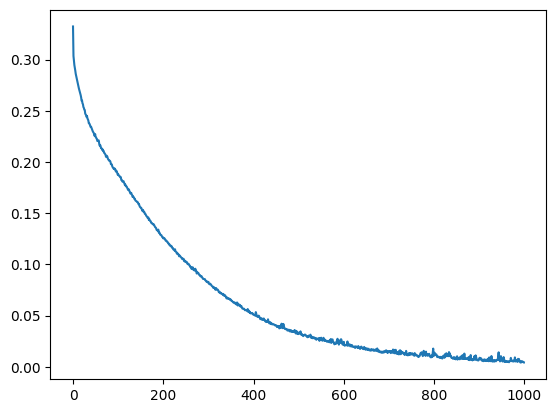

In [ ]:
plt.plot(train_losses.values())

Генерация текста

In [ ]:
def predict(model, dataset, prediction_length=25, start_with=None, static=True):
    model.eval()
    if start_with is None:
        predicted = dataset.vector_to_string([random.randint(0, len(dataset.chars) - 1)])
    else:
        predicted = start_with
    print(predicted)
    hidden = model.init_zero_hidden()

    for i in range(prediction_length - len(predicted)):
        last_char = torch.Tensor([dataset.char_to_idx[predicted[-1]]])
        X, hidden = last_char.to(device), hidden.to(device)
        out, hidden = model(X, hidden)
        if static:
            result = torch.argmax(out).item()
        else:
            result = torch.multinomial(F.softmax(out, dim=1), 1).item()

        letter = dataset.idx_to_char[result]
        if letter == '@':
            break
        predicted += letter

    return predicted

In [ ]:
predict(model, text_dataset, 10, start_with="b")

b


'buhasiaani'

# Доработанная модель с one-hot вектором

Dataset

In [ ]:
class TextDataset(Dataset):
    def __init__(self, text_data, seq_length):
        self.chars = sorted(list(set(text_data)))
        self.data_size, self.vocab_size = len(text_data), len(self.chars)

        self.idx_to_char = {i:ch for i, ch in enumerate(self.chars)}
        self.char_to_idx = {ch:i for i, ch in enumerate(self.chars)}
        self.names = text_data.split('@')
        self.names = [name + '@' for name in self.names if name]

    # преобразование текста в векторы one-hot
    def one_hot_encoder(self, index):
        one_hot = np.zeros(self.vocab_size)
        one_hot[index] = 1
        return one_hot

    # преобразование строки в последовательность векторов
    def string_to_vector(self, name):
        vector = []
        for s in name:
            index = self.char_to_idx[s]
            vector.append(self.one_hot_encoder(index))
        return np.array(vector)

    # преобразование последовательности векторов обратно в строку
    def vector_to_string(self, vector):
        vector_string = ""
        for i in vector:
            index = np.argmax(i)
            vector_string += self.idx_to_char[index]
        return vector_string

    def __len__(self):
        return len(self.names)

    # получение отдельного элемента из набора данных, который возвращает входную и целевую последовательности
    def __getitem__(self, index):
        name = self.names[index]
        X = torch.tensor(self.string_to_vector(name[:-1])).float()
        y = torch.tensor(self.string_to_vector(name[1:])).float()
        return X, y

## Model RNN

### Модель RNN с one-hot вектором

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.input_to_hidden = nn.Linear(input_size, hidden_size) # проецирует входной вектор на скрытое пространство
        self.hidden_to_hidden = nn.Linear(hidden_size, hidden_size) # обновляет скрытое пространство
        self.hidden_to_output = nn.Linear(hidden_size, output_size) # проецирует скрытое сотояние в пространство выходных символов


    def forward(self, x, hidden_state):
        x = self.input_to_hidden(x)
        hidden_state = self.hidden_to_hidden(hidden_state)
        hidden_state = torch.tanh(x + hidden_state)
        out = self.hidden_to_output(hidden_state)
        out = F.softmax(out, dim=-1) # softmax для получения вероятностей
        return out, hidden_state


    def init_zero_hidden(self, batch_size=1):
        return torch.zeros(batch_size, self.hidden_size, requires_grad=False)

Подготовка данных для обучения

In [ ]:
def collate_fn(batch):
    X, Y = zip(*batch)
    X_padded = pad_sequence([x.clone().detach().float() for x in X], batch_first=True, padding_value=0)
    Y_padded = pad_sequence([y.clone().detach().float() for y in Y], batch_first=True, padding_value=0)
    return X_padded, Y_padded

device = 'cuda' if torch.cuda.is_available() else 'cpu'

seq_length = 18
batch_size = 64
hidden_size = 128

text_dataset = TextDataset(data, seq_length=seq_length)

text_dataloader = DataLoader(
    text_dataset,
    batch_size,
    shuffle=True,
    drop_last=True,
    collate_fn=collate_fn
    )

In [ ]:
text_dataset.vector_to_string(text_dataset[0][0].tolist())

'aachenosaurus'

Обучение модели RNN

100%|██████████| 1000/1000 [07:26<00:00,  2.24it/s, epoch=1000, loss=2.5620]


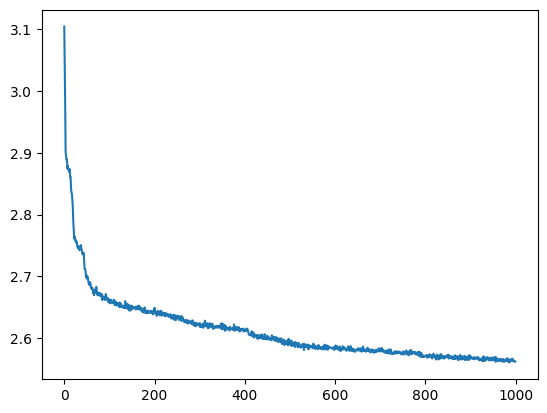

In [ ]:
model = RNN(len(text_dataset.chars), hidden_size, len(text_dataset.chars))

epochs = 1000
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses = {}
model.to(device)
model.train()

pbar = tqdm(range(epochs))
for epoch in pbar:
    epoch_losses = []
    for X, Y in text_dataloader:
        hidden = model.init_zero_hidden(batch_size=batch_size).to(device)
        X, Y, hidden = X.to(device), Y.to(device), hidden.to(device)
        model.zero_grad()

        loss_value = 0
        for c in range(X.shape[1]):
            out, hidden = model(X[:, c, :], hidden)
            loss = loss_fn(out, torch.argmax(Y[:, c, :], dim=-1))
            loss_value += loss

        loss_value.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()

        epoch_losses.append(loss_value.detach().item() / X.shape[1])

    train_losses[epoch] = torch.tensor(epoch_losses).mean()
    pbar.set_postfix({'epoch': f'{epoch +1}', 'loss': f'{train_losses[epoch]:.4f}'})

plt.plot(train_losses.values())



Генерация текста

In [ ]:
def predict(model, dataset,
            prediction_length=25,
            start_with=None,
            static=True,
            temperature=1.0):
    model.eval()
    if start_with is None:
        start_with = random.choice(dataset.chars)

    predicted = start_with
    hidden = model.init_zero_hidden().to(device)

    for i in range(prediction_length - len(predicted)):
        input_seq = [dataset.one_hot_encoder(dataset.char_to_idx[char]) for char in predicted]
        input_seq = np.array(input_seq)
        input_seq = torch.tensor(input_seq).float().unsqueeze(0).to(device)

        for j in range(input_seq.shape[1]):
            out, hidden = model(input_seq[:, j], hidden)

        out = out / temperature

        # Выбираю индекс с наибольшей вероятностью
        next_char_idx = torch.argmax(out).item()

        # Создаю one-hot вектор
        one_hot_output = torch.zeros_like(out)
        one_hot_output[0, next_char_idx] = 1

        next_char = dataset.idx_to_char[next_char_idx]
        if next_char == '@':
            break
        predicted += next_char

    return predicted

In [ ]:
gen_text = predict(model, text_dataset, prediction_length=25, start_with='f', static=False, temperature=2)
print(gen_text)

faalimosaurus


In [ ]:
model

RNN(
  (input_to_hidden): Linear(in_features=27, out_features=128, bias=True)
  (hidden_to_hidden): Linear(in_features=128, out_features=128, bias=True)
  (hidden_to_output): Linear(in_features=128, out_features=27, bias=True)
)

In [ ]:
inp, trg = next(iter(text_dataloader))
inp.shape, trg.shape

(torch.Size([64, 21, 27]), torch.Size([64, 21, 27]))

### RNN без обрезания градиентов

In [ ]:
model_grad_off = RNN(len(text_dataset.chars), hidden_size, len(text_dataset.chars))

epochs = 1000
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses = {}
model.to(device)
model.train()

pbar = tqdm(range(epochs))
for epoch in pbar:
    epoch_losses = []
    for X, Y in text_dataloader:
        hidden = model.init_zero_hidden(batch_size=batch_size).to(device)
        X, Y, hidden = X.to(device), Y.to(device), hidden.to(device)
        model.zero_grad()

        loss_value = 0
        for c in range(X.shape[1]):
            out, hidden = model(X[:, c, :], hidden)
            loss = loss_fn(out, torch.argmax(Y[:, c, :], dim=-1))
            loss_value += loss

        loss_value.backward()
        # Обрезание градиентов отключено:
        # nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()

        epoch_losses.append(loss_value.detach().item() / X.shape[1])

    train_losses[epoch] = torch.tensor(epoch_losses).mean()
    pbar.set_postfix({'epoch': f'{epoch +1}', 'loss': f'{train_losses[epoch]:.4f}'})

100%|██████████| 1000/1000 [07:22<00:00,  2.26it/s, epoch=1000, loss=2.5553]


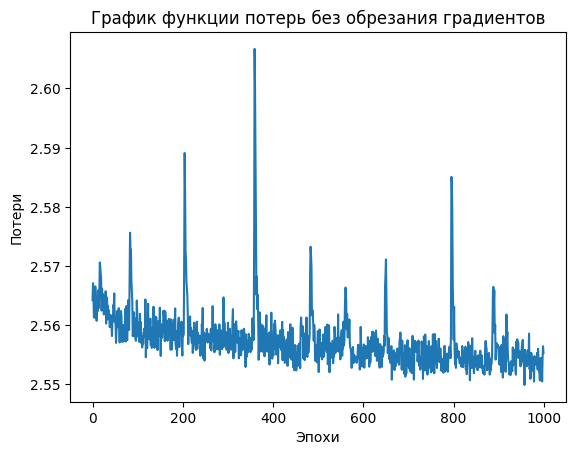

In [ ]:
plt.plot(train_losses.values())
plt.title('График функции потерь без обрезания градиентов')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.show()

In [ ]:
gen_text = predict(model, text_dataset, prediction_length=25, start_with='f', static=False, temperature=2)
print(gen_text)

frantosaurus


### Модель RNN с тремя различными оптимизаторами:

Adam, SGD, RMSprop

In [ ]:
# Создание моделей с оптимизаторами
model_RNN_adam = RNN(len(text_dataset.chars), hidden_size, len(text_dataset.chars))
model_RNN_sgd = RNN(len(text_dataset.chars), hidden_size, len(text_dataset.chars))
model_RNN_rmsprop = RNN(len(text_dataset.chars), hidden_size, len(text_dataset.chars))

# Оптимизаторы: Adam, SGD и RMSprop
optimizer_RNN_adam = optim.Adam(model_RNN_adam.parameters(), lr=0.001)
optimizer_RNN_sgd = optim.SGD(model_RNN_sgd.parameters(), lr=0.001, momentum=0.9)
optimizer_RNN_rmsprop = optim.RMSprop(model_RNN_rmsprop.parameters(), lr=0.001)

In [ ]:
# Словари для хранения потерь
train_losses_RNN_adam = {}
train_losses_RNN_sgd = {}
train_losses_RNN_rmsprop = {}

# Функция для обучения модели
def train_RNN_model(model, optimizer, epochs, train_losses):
    model.to(device)
    model.train()

    loss_fn = nn.CrossEntropyLoss()
    pbar = tqdm(range(epochs))

    for epoch in pbar:
        epoch_losses = []
        for X, Y in text_dataloader:
            hidden = model.init_zero_hidden(batch_size=batch_size).to(device)
            X, Y, hidden = X.to(device), Y.to(device), hidden.to(device)
            model.zero_grad()

            loss_value = 0
            for c in range(X.shape[1]):
                out, hidden = model(X[:, c, :], hidden)
                loss = loss_fn(out, torch.argmax(Y[:, c, :], dim=-1))
                loss_value += loss

            loss_value.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            optimizer.step()

            epoch_losses.append(loss_value.detach().item() / X.shape[1])

        train_losses[epoch] = torch.tensor(epoch_losses).mean()
        pbar.set_postfix({'epoch': f'{epoch + 1}', 'loss': f'{train_losses[epoch]:.4f}'})

In [ ]:
# Обучение моделей
train_RNN_model(model_RNN_adam, optimizer_RNN_adam, epochs=1000, train_losses=train_losses_RNN_adam)
train_RNN_model(model_RNN_sgd, optimizer_RNN_sgd, epochs=1000, train_losses=train_losses_RNN_sgd)
train_RNN_model(model_RNN_rmsprop, optimizer_RNN_rmsprop, epochs=1000, train_losses=train_losses_RNN_rmsprop)

100%|██████████| 1000/1000 [07:36<00:00,  2.19it/s, epoch=1000, loss=2.5698]


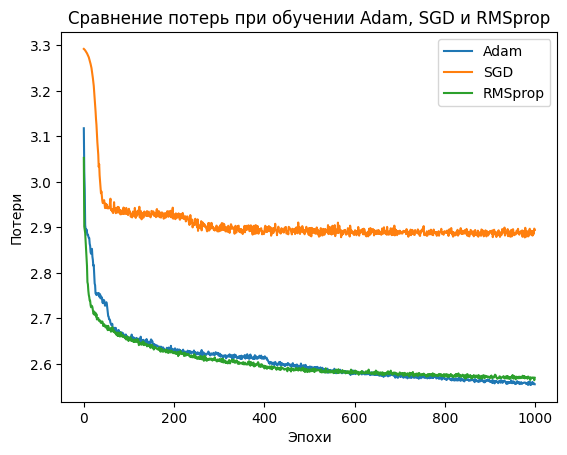

In [ ]:
# Построение графиков потерь для всех трех моделей
plt.plot(train_losses_RNN_adam.values(), label='Adam')
plt.plot(train_losses_RNN_sgd.values(), label='SGD')
plt.plot(train_losses_RNN_rmsprop.values(), label='RMSprop')
plt.legend()
plt.title('Сравнение потерь при обучении Adam, SGD и RMSprop')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.show()

In [ ]:
# Генерация текста для каждой модели
gen_text_RNN_adam = predict(model_RNN_adam, text_dataset, prediction_length=25, start_with='f', static=False, temperature=2)
gen_text_RNN_sgd = predict(model_RNN_sgd, text_dataset, prediction_length=25, start_with='f', static=False, temperature=2)
gen_text_RNN_rmsprop = predict(model_RNN_rmsprop, text_dataset, prediction_length=25, start_with='f', static=False, temperature=2)

print("Генерация с Adam:", gen_text_RNN_adam)
print("Генерация с SGD:", gen_text_RNN_sgd)
print("Генерация с RMSprop:", gen_text_RNN_rmsprop)

Генерация с Adam: fana
Генерация с SGD: faaa
Генерация с RMSprop: fenia


### Обучение RNN, используя разную длину вектора hidden_state

In [ ]:
# Выбираю значения для hidden_state
hidden_sizes = [64, 128, 256]

# Словари для хранения потерь
train_losses_64 = {}
train_losses_128 = {}
train_losses_256 = {}

In [ ]:
# Функция для обучения модели
def train_model_with_hidden_size(hidden_size, train_losses, epochs=1000):
    model = RNN(len(text_dataset.chars), hidden_size, len(text_dataset.chars))  # создание модели с разным hidden_size
    optimizer = optim.Adam(model.parameters(), lr=0.001)  # использую Adam для всех моделей
    model.to(device)
    model.train()

    loss_fn = nn.CrossEntropyLoss()
    pbar = tqdm(range(epochs))

    for epoch in pbar:
        epoch_losses = []
        for X, Y in text_dataloader:
            hidden = model.init_zero_hidden(batch_size=batch_size).to(device)
            X, Y, hidden = X.to(device), Y.to(device), hidden.to(device)
            model.zero_grad()

            loss_value = 0
            for c in range(X.shape[1]):
                out, hidden = model(X[:, c, :], hidden)
                loss = loss_fn(out, torch.argmax(Y[:, c, :], dim=-1))
                loss_value += loss

            loss_value.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            optimizer.step()

            epoch_losses.append(loss_value.detach().item() / X.shape[1])

        train_losses[epoch] = torch.tensor(epoch_losses).mean()
        pbar.set_postfix({'epoch': f'{epoch + 1}', 'loss': f'{train_losses[epoch]:.4f}'})

    return model


In [ ]:
# Обучение моделей с разными значениями hidden_size
model_RNN_64 = train_model_with_hidden_size(hidden_size=64, train_losses=train_losses_64)
model_RNN_128 = train_model_with_hidden_size(hidden_size=128, train_losses=train_losses_128)
model_RNN_256 = train_model_with_hidden_size(hidden_size=256, train_losses=train_losses_256)

100%|██████████| 1000/1000 [07:35<00:00,  2.20it/s, epoch=1000, loss=2.5252]


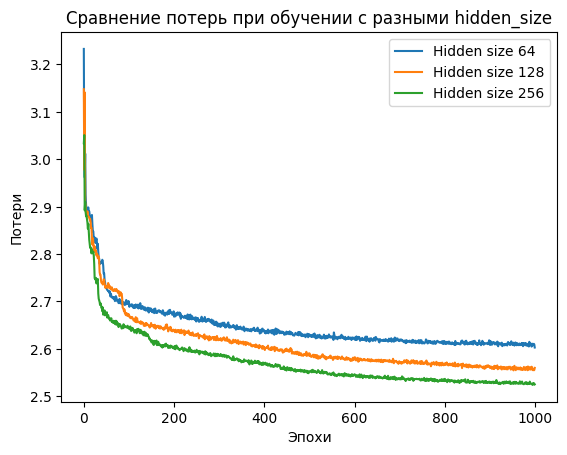

In [ ]:
# Построение графиков потерь для всех трех моделей
plt.plot(train_losses_64.values(), label='Hidden size 64')
plt.plot(train_losses_128.values(), label='Hidden size 128')
plt.plot(train_losses_256.values(), label='Hidden size 256')
plt.legend()
plt.title('Сравнение потерь при обучении с разными hidden_size')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.show()

In [ ]:
# Генерация текста для каждой модели
gen_text_RNN_64 = predict(model_RNN_64, text_dataset, prediction_length=25, start_with='f', static=False, temperature=2)
gen_text_RNN_128 = predict(model_RNN_128, text_dataset, prediction_length=25, start_with='f', static=False, temperature=2)
gen_text_RNN_256 = predict(model_RNN_256, text_dataset, prediction_length=25, start_with='f', static=False, temperature=2)

# Вывод результатов
print("Генерация текста с hidden_size=64:", gen_text_RNN_64)
print("Генерация текста с hidden_size=128:", gen_text_RNN_128)
print("Генерация текста с hidden_size=256:", gen_text_RNN_256)

Генерация текста с hidden_size=64: faran
Генерация текста с hidden_size=128: fanos
Генерация текста с hidden_size=256: feng


## Model LSTM

### Model LSTM c one-hot вектором

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int, dropout_prob=0.2):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout = nn.Dropout(dropout_prob)

        # Forget gate
        self.hidden_to_forget = nn.Linear(hidden_size, hidden_size)
        self.x_to_forget = nn.Linear(input_size, hidden_size)

        # Input gate
        self.hidden_to_i_input = nn.Linear(hidden_size, hidden_size)
        self.x_to_i_input = nn.Linear(input_size, hidden_size)
        self.hidden_to_context = nn.Linear(hidden_size, hidden_size)
        self.x_to_context = nn.Linear(input_size, hidden_size)

        # Output gate
        self.hidden_to_output = nn.Linear(hidden_size, hidden_size)
        self.x_to_output = nn.Linear(input_size, hidden_size)

        # Final output layer
        self.hidden_to_y = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, context):
        # Forget gate
        forget_out = torch.sigmoid(self.hidden_to_forget(hidden) + self.x_to_forget(x))
        context = context * forget_out

        # Input gate
        i = torch.sigmoid(self.hidden_to_i_input(hidden) + self.x_to_i_input(x))
        input_context = torch.tanh(self.hidden_to_context(hidden) + self.x_to_context(x))
        context = context + i * input_context

        # Output gate
        output = torch.sigmoid(self.hidden_to_output(hidden) + self.x_to_output(x))
        context_to_out = torch.tanh(context)
        hidden = context_to_out * output

        # Dropout для регуляризации
        hidden = self.dropout(hidden)

        # Final output
        y = self.hidden_to_y(hidden)
        return y, hidden, context

    def init_zero_hidden(self, batch_size):
        # Инициализация скрытого состояния и контекста нулями
        return torch.zeros(batch_size, self.hidden_size)

In [ ]:
class TextDataset(Dataset):
    def __init__(self, text_data, seq_length):
        self.chars = sorted(list(set(text_data)))
        self.data_size, self.vocab_size = len(text_data), len(self.chars)

        self.idx_to_char = {i:ch for i, ch in enumerate(self.chars)}
        self.char_to_idx = {ch:i for i, ch in enumerate(self.chars)}
        self.names = text_data.split('@')
        self.names = [name + '@' for name in self.names if name]

    # One-hot encoding для символа
    def one_hot_encoder(self, index):
        one_hot = np.zeros(self.vocab_size)
        one_hot[index] = 1
        return one_hot

    # Преобразование строки в последовательность one-hot векторов
    def string_to_vector(self, name):
        vector = [self.one_hot_encoder(self.char_to_idx[ch]) for ch in name]
        return np.array(vector)

    def __len__(self):
        return len(self.names)

    def __getitem__(self, index):
        name = self.names[index]
        X = torch.tensor(self.string_to_vector(name[:-1])).float()  # one-hot encoding входной последовательности
        y = torch.tensor(self.string_to_vector(name[1:])).float()   # one-hot encoding целевой последовательности
        return X, y

In [ ]:
def collate_fn(batch):
    X, Y = zip(*batch)
    X_padded = pad_sequence([x.clone().detach().float() for x in X], batch_first=True, padding_value=0)
    Y_padded = pad_sequence([y.clone().detach().float() for y in Y], batch_first=True, padding_value=0)
    return X_padded, Y_padded

In [ ]:
def predict(model, dataset, prediction_length=25, start_with=None, static=True, temperature=1.0):
    model.eval()

    # Выбираем стартовый символ
    if start_with is None:
        start_with = random.choice(dataset.chars)

    predicted = start_with
    hidden = model.init_zero_hidden(batch_size=1).to(device)
    context = model.init_zero_hidden(batch_size=1).to(device)

    for _ in range(prediction_length - len(predicted)):
        # Prepare input: one-hot vector
        input_seq = torch.zeros(1, len(dataset.chars)).float().to(device)  # Батч 1
        input_seq[0, dataset.char_to_idx[predicted[-1]]] = 1

        out, hidden, context = model(input_seq.unsqueeze(0), hidden, context)

        # Делим на температуру для управления случайностью
        out = out / temperature

        if static:
            # Жесткий отбор символа
            next_char_idx = torch.argmax(out).item()
        else:
            # Использование вероятностей для выбора символа
            probabilities = F.softmax(out.squeeze(), dim=0)  # Убираем лишние измерения
            next_char_idx = torch.multinomial(probabilities, 1).item()

        next_char = dataset.idx_to_char[next_char_idx]

        # Прерываем генерацию, если достигнут символ окончания
        if next_char == '@':
            break
        predicted += next_char

    return predicted

In [ ]:
# Пайплайн для обучения модели LSTM
text_dataset = TextDataset(data, seq_length=seq_length)
text_dataloader = DataLoader(text_dataset, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=collate_fn)

# Определяем модель LSTM
model_LSTM = LSTM(input_size=len(text_dataset.chars), hidden_size=hidden_size, output_size=len(text_dataset.chars))
model_LSTM.to(device)

# Задаем параметры обучения
epochs = 1000
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_LSTM.parameters(), lr=0.001)

train_losses = {}
model_LSTM.train()

pbar = tqdm(range(epochs))
for epoch in pbar:
    model_LSTM.train()
    epoch_losses = []
    for X, Y in text_dataloader:
        hidden = model_LSTM.init_zero_hidden(batch_size=X.size(0)).to(device)
        context = model_LSTM.init_zero_hidden(batch_size=X.size(0)).to(device)

        X, Y = X.to(device), Y.to(device)
        model_LSTM.zero_grad()

        loss_value = 0
        for c in range(X.shape[1]):
            out, hidden, context = model_LSTM(X[:, c, :], hidden, context)
            loss = loss_fn(out, torch.argmax(Y[:, c, :], dim=1))
            loss_value += loss

        loss_value.backward()
        nn.utils.clip_grad_norm_(model_LSTM.parameters(), 2)  # Ограничение градиентов
        optimizer.step()

        epoch_losses.append(loss_value.item() / X.shape[1])

    train_losses[epoch] = torch.tensor(epoch_losses).mean()
    pbar.set_postfix({'epoch': f'{epoch + 1}', 'loss': f'{train_losses[epoch]:.4f}'})

    # Промежуточная проверка через каждые 100 эпох
    if (epoch + 1) % 100 == 0:
        print(f'--- Epoch {epoch + 1} ---')
        sample_text = predict(model_LSTM, text_dataset, prediction_length=25, start_with='f', static=False, temperature=2)
        print(f'Generated text: {sample_text}')

 10%|█         | 100/1000 [02:12<19:54,  1.33s/it, epoch=100, loss=0.8424]

--- Epoch 100 ---
Generated text: fe


 20%|██        | 200/1000 [04:23<18:36,  1.40s/it, epoch=200, loss=0.6948]

--- Epoch 200 ---
Generated text: fectagranosauras


 30%|███       | 300/1000 [06:34<15:49,  1.36s/it, epoch=300, loss=0.6054]

--- Epoch 300 ---
Generated text: feluetuiken


 40%|████      | 400/1000 [08:47<13:28,  1.35s/it, epoch=400, loss=0.5575]

--- Epoch 400 ---
Generated text: fokana


 50%|█████     | 500/1000 [10:59<11:05,  1.33s/it, epoch=500, loss=0.5428]

--- Epoch 500 ---
Generated text: fusavenator


 60%|██████    | 600/1000 [13:11<09:12,  1.38s/it, epoch=600, loss=0.5309]

--- Epoch 600 ---
Generated text: fusuisaurus


 70%|███████   | 700/1000 [15:21<06:02,  1.21s/it, epoch=700, loss=0.5045]

--- Epoch 700 ---
Generated text: fuahsaurus


 80%|████████  | 800/1000 [17:32<03:59,  1.20s/it, epoch=800, loss=0.4988]

--- Epoch 800 ---
Generated text: fungserui


 90%|█████████ | 900/1000 [19:43<02:07,  1.27s/it, epoch=900, loss=0.4749]

--- Epoch 900 ---
Generated text: fomurisaurus


100%|██████████| 1000/1000 [21:58<00:00,  1.32s/it, epoch=1000, loss=0.4745]

--- Epoch 1000 ---
Generated text: fvitruisaurus


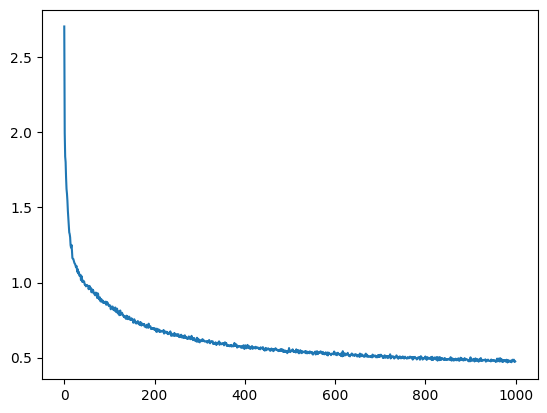

In [ ]:
plt.plot(train_losses.values())

Генерация текста

In [ ]:
# Генерация текста с обученной LSTM моделью
gen_text = predict(model_LSTM, text_dataset, prediction_length=25, start_with='f', static=False, temperature=2)
print(gen_text)

ffeduacpesaurus


### Модель LSTM с тремя различными оптимизаторами:

Adam, SGD, RMSprop

In [ ]:
# Создание моделей с оптимизаторами
model_LSTM_adam = LSTM(len(text_dataset.chars), hidden_size, len(text_dataset.chars))
model_LSTM_sgd = LSTM(len(text_dataset.chars), hidden_size, len(text_dataset.chars))
model_LSTM_rmsprop = LSTM(len(text_dataset.chars), hidden_size, len(text_dataset.chars))

# Оптимизаторы: Adam, SGD и RMSprop
optimizer_LSTM_adam = optim.Adam(model_LSTM_adam.parameters(), lr=0.001)
optimizer_LSTM_sgd = optim.SGD(model_LSTM_sgd.parameters(), lr=0.001, momentum=0.9)
optimizer_LSTM_rmsprop = optim.RMSprop(model_LSTM_rmsprop.parameters(), lr=0.001)

In [ ]:
# Словари для хранения потерь
train_losses_LSTM_adam = {}
train_losses_LSTM_sgd = {}
train_losses_LSTM_rmsprop = {}

def train_LSTM_model(model, optimizer, epochs, train_losses):
    model.to(device)
    model.train()

    loss_fn = nn.CrossEntropyLoss()
    pbar = tqdm(range(epochs))

    for epoch in pbar:
        epoch_losses = []
        for X, Y in text_dataloader:
            hidden = model.init_zero_hidden(batch_size=batch_size).to(device)
            context = model.init_zero_hidden(batch_size=batch_size).to(device)  # Инициализация контекста
            X, Y = X.to(device), Y.to(device)
            model.zero_grad()

            loss_value = 0
            for c in range(X.shape[1]):
                out, hidden, context = model(X[:, c, :], hidden, context)  # Передача context
                loss = loss_fn(out, torch.argmax(Y[:, c, :], dim=-1))
                loss_value += loss

            loss_value.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            optimizer.step()

            epoch_losses.append(loss_value.detach().item() / X.shape[1])

        train_losses[epoch] = torch.tensor(epoch_losses).mean()
        pbar.set_postfix({'epoch': f'{epoch + 1}', 'loss': f'{train_losses[epoch]:.4f}'})

In [ ]:
def predict(model, dataset, prediction_length=25, start_with=None, static=True, temperature=1.0):
    model.eval()

    # Выбираем стартовый символ
    if start_with is None:
        start_with = random.choice(dataset.chars)

    predicted = start_with
    hidden = model.init_zero_hidden(batch_size=1).to(device)
    context = model.init_zero_hidden(batch_size=1).to(device)  # Инициализация контекста

    for _ in range(prediction_length - len(predicted)):
        # Prepare input: one-hot vector
        input_seq = torch.zeros(1, len(dataset.chars)).float().to(device)
        input_seq[0, dataset.char_to_idx[predicted[-1]]] = 1

        out, hidden, context = model(input_seq.unsqueeze(0), hidden, context)  # Передача context

        # Делим на температуру для управления случайностью
        out = out / temperature

        if static:
            # Жесткий отбор символа
            next_char_idx = torch.argmax(out).item()
        else:
            # Использование вероятностей для выбора символа
            probabilities = F.softmax(out, dim=1).squeeze()
            next_char_idx = torch.multinomial(probabilities, 1).item()

        next_char = dataset.idx_to_char[next_char_idx]

        # Прерываем генерацию, если достигнут символ окончания
        if next_char == '@':
            break
        predicted += next_char

    return predicted

In [ ]:
# Обучение моделей
train_LSTM_model_adam = train_LSTM_model(model_LSTM_adam, optimizer_LSTM_adam, epochs=1000, train_losses=train_losses_LSTM_adam)
train_LSTM_model_sgd = train_LSTM_model(model_LSTM_sgd, optimizer_LSTM_sgd, epochs=1000, train_losses=train_losses_LSTM_sgd)
train_LSTM_model_rmsprop = train_LSTM_model(model_LSTM_rmsprop, optimizer_LSTM_rmsprop, epochs=1000, train_losses=train_losses_LSTM_rmsprop)

100%|██████████| 1000/1000 [21:45<00:00,  1.31s/it, epoch=1000, loss=0.4784]


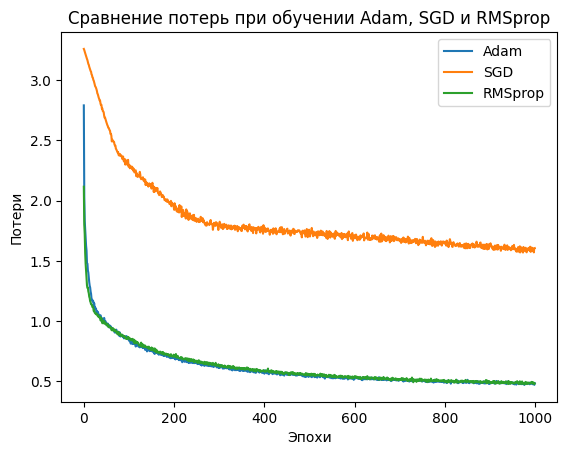

In [ ]:
# Построение графиков потерь для всех трех моделей
plt.plot(train_losses_LSTM_adam.values(), label='Adam')
plt.plot(train_losses_LSTM_sgd.values(), label='SGD')
plt.plot(train_losses_LSTM_rmsprop.values(), label='RMSprop')
plt.legend()
plt.title('Сравнение потерь при обучении Adam, SGD и RMSprop')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.show()

In [ ]:
# Генерация текста для каждой модели
gen_text_LSTM_adam = predict(model_LSTM_adam, text_dataset, prediction_length=25, start_with='f', static=False, temperature=2)
gen_text_LSTM_sgd = predict(model_LSTM_sgd, text_dataset, prediction_length=25, start_with='f', static=False, temperature=2)
gen_text_LSTM_rmsprop = predict(model_LSTM_rmsprop, text_dataset, prediction_length=25, start_with='f', static=False, temperature=2)

print("Генерация с Adam:", gen_text_LSTM_adam)
print("Генерация с SGD:", gen_text_LSTM_sgd)
print("Генерация с RMSprop:", gen_text_LSTM_rmsprop)

Генерация с Adam: frubklyzgainjcbpmlgdyaeve
Генерация с SGD: fzzlxaunknaqcjnrafcugrydn
Генерация с RMSprop: f


### Обучение LSTM с таким количеством эпох, которое соответствует времени обучения RNN

In [ ]:
# RNN
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.i2h = nn.Linear(hidden_size, hidden_size)
        self.i2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        input = input.long()
        embedded = self.embedding(input).view(-1, self.hidden_size)
        hidden = self.i2h(embedded) + hidden
        output = self.i2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def init_zero_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size, device=device)

In [ ]:
# LSTM
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=1, batch_first=True)
        self.i2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    @staticmethod
    def init_hidden(batch_size, hidden_size):
        return torch.zeros(1, batch_size, hidden_size).to(device)

    def forward(self, input, hidden, context):
        input = input.long()
        embedded = self.embedding(input)  # [batch_size, seq_length, hidden_size]
        out, (hidden, context) = self.lstm(embedded, (hidden, context))
        out = self.i2o(out)  # [batch_size, seq_length, hidden_size] -> [batch_size, seq_length, output_size]
        return out, hidden, context

In [ ]:
# Инициализация device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Загрузка dataset и создание data loader
text_dataset = TextDataset(data, seq_length=seq_length)
text_dataloader = DataLoader(text_dataset, batch_size, shuffle=True, drop_last=True)
batch_size = 64

# Параметры
input_size = len(text_dataset.chars)
hidden_size = 128
output_size = input_size

In [ ]:
model_RNN_adam = RNN(input_size, hidden_size, output_size)
optimizer_RNN_adam = optim.Adam(model_RNN_adam.parameters(), lr=0.001)

model_LSTM_adam = LSTM(input_size, hidden_size, output_size)
optimizer_LSTM_adam = optim.Adam(model_LSTM_adam.parameters(), lr=0.001)

In [ ]:
def train_rnn_with_timing(model, optimizer, epochs, train_losses):
    model.to(device)
    model.train()

    loss_fn = nn.CrossEntropyLoss()
    start_time = time.time()

    for epoch in tqdm(range(epochs)):
        epoch_losses = []
        for X, Y in text_dataloader:
            X, Y = X.to(device), Y.to(device)
            X = X.long()  # Приведение X к LongTensor
            Y = Y.long()  # Приведение Y к LongTensor
            hidden = model.init_zero_hidden(batch_size=X.size(0)).to(device)

            model.zero_grad()

            loss_value = 0
            for c in range(X.shape[1]):  # Проход по временным шагам
                input_timestep = X[:, c]  # Индексы символов для текущего временного шага
                out, hidden = model(input_timestep, hidden)
                loss = loss_fn(out, Y[:, c])  # Loss для каждого временного шага
                loss_value += loss

            loss_value.backward()
            optimizer.step()

            epoch_losses.append(loss_value.item() / X.shape[1])  # Усредняем loss по длине последовательности

        train_losses[epoch] = torch.tensor(epoch_losses).mean()

    total_time = time.time() - start_time
    return total_time

In [ ]:
def train_lstm_one_epoch(model, optimizer, train_losses):
    model.to(device)
    model.train()

    loss_fn = nn.CrossEntropyLoss()
    epoch_losses = []
    start_time = time.time()  # Запуск таймера

    for X, Y in text_dataloader:
        X, Y = X.to(device), Y.to(device)
        X = X.long()  # Приведение X к LongTensor
        Y = Y.long()  # Приведение Y к LongTensor

        # Инициализация скрытого состояния и контекста
        hidden = model.init_hidden(X.size(0), model.hidden_size).to(device)
        context = torch.zeros(1, X.size(0), model.hidden_size).to(device)

        model.zero_grad()

        loss_value = 0

        # Передача данных в LSTM (всю последовательность)
        out, hidden, context = model(X, hidden, context)

        # Извлечение последнего временного шага
        out = out[:, -1, :]  # [batch_size, hidden_size] -> [batch_size, output_size]
        Y = Y[:, -1]  # Соответствующее целевое значение для последнего временного шага

        # Вычисление потерь
        loss = loss_fn(out, Y)  # Теперь размеры batch_size совпадают
        loss_value += loss

        loss_value.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()

        epoch_losses.append(loss_value.detach().item())

    train_losses[0] = torch.tensor(epoch_losses).mean()
    epoch_time_lstm = time.time() - start_time  # Время одной эпохи для LSTM
    return epoch_time_lstm

In [ ]:
def train_lstm_with_timing(model, optimizer, epochs, train_losses):
    model.to(device)
    model.train()

    loss_fn = nn.CrossEntropyLoss()
    pbar = tqdm(range(epochs))

    for epoch in pbar:
        epoch_losses = []
        for X, Y in text_dataloader:
            X, Y = X.to(device), Y.to(device)
            X = X.long()  # Приведение X к LongTensor
            Y = Y.long()  # Приведение Y к LongTensor

            # Инициализация скрытого состояния и контекста
            hidden = model.init_hidden(X.size(0), model.hidden_size).to(device)
            context = torch.zeros(1, X.size(0), model.hidden_size).to(device)

            model.zero_grad()

            loss_value = 0

            # Передача данных в LSTM
            out, hidden, context = model(X, hidden, context)

            # Извлечение последнего временного шага
            out = out[:, -1, :]  # [batch_size, seq_length, output_size] -> [batch_size, output_size]
            Y = Y[:, -1]  # Для расчета потерь используем последний временной шаг

            # Вычисление потерь
            loss = loss_fn(out, Y)
            loss_value += loss

            loss_value.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            optimizer.step()

            epoch_losses.append(loss_value.detach().item())

        train_losses[epoch] = torch.tensor(epoch_losses).mean()
        pbar.set_postfix({'epoch': f'{epoch + 1}', 'loss': f'{train_losses[epoch]:.4f}'})

In [ ]:
# Обучение модели RNN
train_losses_RNN_adam = {}
total_time_rnn = train_rnn_with_timing(model_RNN_adam, optimizer_RNN_adam, epochs=1000, train_losses=train_losses_RNN_adam)

100%|██████████| 1000/1000 [04:10<00:00,  3.99it/s]


In [ ]:
# ОБучение модели LSTM для одной эпохи
train_losses_LSTM_adam = {}
epoch_time_lstm = train_lstm_one_epoch(model_LSTM_adam, optimizer_LSTM_adam, train_losses=train_losses_LSTM_adam)

# Рассчет количества эпох для модели LSTM
epochs_lstm = int(total_time_rnn / epoch_time_lstm)
print(f"Количество эпох для LSTM, чтобы соответствовать времени RNN: {epochs_lstm}")

# Обучение модель LSTM с рассчитанным количеством эпох
train_lstm_with_timing(model_LSTM_adam, optimizer_LSTM_adam, epochs=epochs_lstm, train_losses=train_losses_LSTM_adam)

Количество эпох для LSTM, чтобы соответствовать времени RNN: 3006


100%|██████████| 3006/3006 [04:17<00:00, 11.65it/s, epoch=3006, loss=0.0000]


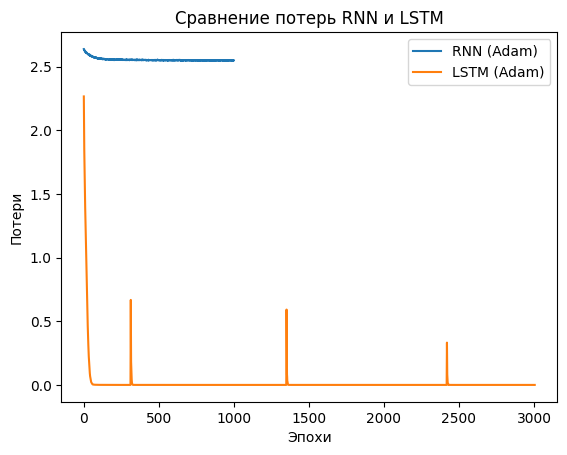

In [ ]:
# Построение графиков потерь для RNN и LSTM
plt.plot(list(train_losses_RNN_adam.values()), label='RNN (Adam)')
plt.plot(list(train_losses_LSTM_adam.values()), label='LSTM (Adam)')
plt.legend()
plt.title('Сравнение потерь RNN и LSTM')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.show()